# Integrantes

Álvaro Rodríguez  
Alfredo Aponte  
Universidad ICESI  
Asignatura Fundamentos de Analítica II
Octubre de 2024

# Contexto


*(Ver documentación en https://www.kaggle.com/competitions/fa-ii-2024-ii-flujos-de-modelos-tradicionales/overview)*  

El cáncer de próstata es uno de los tipos de cáncer más comunes en hombres. La detección temprana es crucial para mejorar las tasas de supervivencia. La prueba de antígeno prostático específico (PSA) puede ayudar a detectar el cáncer de próstata en etapas tempranas, cuando es más tratable. Sin embargo, el PSA no es específico para el cáncer de próstata y puede estar elevado en otras condiciones como prostatitis o hiperplasia prostática benigna (HPB).

El antígeno prostático específico (PSA) es una proteína producida por células normales y malignas de la glándula prostática. La prueba del PSA mide el nivel de esta proteína en la sangre y es uno de los métodos más utilizados para el tamizaje del cáncer de próstata.

La EPS SaludPorTi, está interesado en priorizar la toma de está prueba, aumentando la demanda y detención temprana del Cáncer de Próstata.

**Problema de negocio**

La empresa ha decidido contratarlos para que construyan un modelo predictivo que permita estimar la probabilidad de que un usuario entre 48 y 60 años de edad presente resultados anormales de PSA.

**Contexto analítico**

Se espera que entrene diferentes familias de modelos predictivos de clasificación (SVC con diferentes kernels, Redes Neuronales poco profundas), precedidos por diferentes procesos de transformación (normalizaciones, imputación, feature engineering, dummificación, PCA, selección de features).

La evaluación de la calidad de los flujos de modelos predictivos se debe estimar utilizando la métrica de ROC_AUC.

Expliquen sus ideas, el por qué realizan las acciones, y comenten los resultados obtenidos; se espera mucho más que unos bloques de código.  

La toma de decisiones sobre los datos se debe hacer considerando el contexto del problema y de los datos, no se puede ver todo solamente desde los ojos de los datos, sino también considerar el negocio.  

Un Científico de Datos debe poder comunicar los puntos importantes de su trabajo en un lenguaje universal para todos los públicos.  

Todo esto se considerará en la nota.

# 0.  Importación de librerías y paquetes

In [15]:
#!pip install scikit-optimize
#!pip install optuna
#!pip install pycaret
#from pycaret.classification import setup, compare_models, tune_model, evaluate_model
#from pycaret.classification import *
import pandas as pd                                             #Importar libreria pandas para leer archivo parquet
pd.set_option('display.float_format', '{:.2f}'.format)          #Formatro decimal para el display de los datos
from scipy.stats import skew, kurtosis, chi2_contingency          #Importar libreria scipy para calcular skew y kurtosis
import seaborn as sns                                           #Importar libreria seaborn para graficar
from sklearn.model_selection import train_test_split, RandomizedSearchCV            #Importar libreria sklearn para separar datos en train y test
from sklearn.dummy import DummyClassifier                       #Importar libreria sklearn para crear clasificador dummy
from sklearn.metrics import roc_auc_score, roc_curve, auc       #Importar libreria sklearn para calcular metricas de clasificacion binaria
import matplotlib.pyplot as plt                                 #Importar libreria matplotlib para graficar
import numpy as np                                              #Importar libreria numpy para calculos matematicos
from sklearn.pipeline import Pipeline                           #Importar libreria sklearn para crear pipelines
from sklearn.base import BaseEstimator, TransformerMixin        #La clase ColumnSelector hereda de BaseEstimator y TransformerMixin, lo que permite integrarse fácilmente en un pipeline de scikit-learn
from sklearn.impute import SimpleImputer                        #Importar libreria sklearn para imputar valores faltantes
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler #Importar libreria sklearn para escalar y codificar variables
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression             #Importar libreria sklearn para crear modelo de regresion logistica
from sklearn.svm import SVC                                     #Importar libreria sklearn para crear modelo de SVM
from skopt import BayesSearchCV                                 #Importar libreria skopt para optimizar hiperparametros
from skopt.space import Real, Integer                           #Importar libreria skopt para definir espacio de busqueda de hiperparametros
import optuna                                                   #Importar libreria optuna para optimizar hiperparametros
from sklearn.ensemble import RandomForestClassifier             #Importar libreria sklearn para crear modelo de Random Forest
from sklearn.model_selection import train_test_split            #
from sklearn.ensemble import RandomForestClassifier             #
from sklearn.neural_network import MLPClassifier                #Importar libreria sklearn para crear modelo de redes neuronales

# 1.  Comprensión y análisis de los datos

Objetivo: obtener un entendimiento claro de los datos y realizar un preprocesamiento de los mismos.

## 1.1.  Análisis exploratorio de los datos (EDA)

### 1.1.1. Carga y revisión del conjunto de datos

In [16]:
#Vista general del conjunnto de datos de entrenamiento
train_dataset = pd.read_parquet ("df_train.parquet")
data_df = pd.read_parquet ("df_train.parquet")
train_dataset

,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.00,3.00,3.00,2,0.00,NaN,0.00,NaN,NaN,0.00,...,0,0,0,0,0,0,0,58373.06,-110021.20,188569.00
11528,6.00,1.00,1.00,2,0.50,NaN,0.00,NaN,NaN,1.00,...,0,0,0,0,0,0,0,19618.94,-36176.13,97470.50
26630,1.00,0.00,2.00,2,0.00,NaN,0.00,NaN,NaN,0.00,...,0,0,0,0,0,0,1,398534.00,-626628.00,2304723.00
12586,6.00,0.00,2.00,2,0.00,NaN,0.00,NaN,NaN,0.00,...,0,0,0,0,0,0,0,1292.60,13410.73,53804.50
11225,3.00,0.00,2.00,1,1.00,NaN,0.00,NaN,NaN,1.00,...,2,2,2,2,2,2,0,13728.71,-27375.67,41349.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,0.00,0.00,1.00,3,0.00,NaN,0.00,NaN,NaN,0.00,...,0,0,0,0,0,0,0,6628.57,-15466.67,46400.00
15417,6.00,0.00,3.00,1,1.00,NaN,0.00,NaN,NaN,1.00,...,2,2,2,2,2,2,0,36161.14,-66307.33,90385.00
19389,8.00,2.00,2.00,1,0.00,NaN,0.00,NaN,NaN,0.00,...,2,2,2,2,2,2,0,15912.89,16190.07,107827.75


Encontramos que tenemos un dataset para entrenamiento de 23.494 filas por 46 train_dataset

In [17]:
#Información del conjunto de datos de entrenamiento
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23494 entries, 16484 to 9409
Data columns (total 46 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   23494 non-null  float64
 1   MEDICINA ESPECIALIZADA         23494 non-null  float64
 2   MEDICINA GENERAL               23494 non-null  float64
 3   Cant_gr_flia                   23494 non-null  int64  
 4   Cant_riesgos_flia_mean         23494 non-null  float64
 5   min_Tiempo_CP_Fliar            8 non-null      float64
 6   Cant_Fliar_CP                  23494 non-null  float64
 7   psa_max_gr_flia                164 non-null    float64
 8   psa_min_gr_flia                164 non-null    float64
 9   Cant_Fliar_riesgos             23494 non-null  float64
 10  cantidad_serv_flia             23494 non-null  float64
 11  Pendiente_flia                 23494 non-null  float64
 12  Intercepto_flia                23494 non-null  f

Se observan diferente tipos de columnas y se destacan ciertos campos con gran cantidad de nulos.  Estas columnas deberán eliminarse en una etapa posterior.

In [18]:
#Analisis descriptivo de los campos numericos
train_dataset_numerico = train_dataset.select_dtypes(include=['float64','int64', 'int32'])
tabla_descriptivas = train_dataset_numerico.describe()
tabla_descriptivas.loc['coef. variation 0.30 | 0.30-0.70 | 0.70'] = train_dataset_numerico.std() / train_dataset_numerico.mean()
tabla_descriptivas.loc['skew < 0 sesgo izquierda | > 0 sesgo derecha '] = skew(train_dataset_numerico)
tabla_descriptivas.loc['kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica'] = kurtosis(train_dataset_numerico)
q1 = train_dataset_numerico.quantile(0.25)
q3 = train_dataset_numerico.quantile(0.75)
IQR = q3 - q1
outlier_minimos = train_dataset_numerico < (q1 - 1.5 * IQR)
outlier_maximos = train_dataset_numerico > (q3 + 1.5 * IQR)
tabla_descriptivas.loc['Umbral atípicos minimo'] = q1 - 1.5 * IQR
tabla_descriptivas.loc['Umbral atípicos maximo'] = q3 + 1.5 * IQR
tabla_descriptivas.loc['cantidad atipicos minimos'] = outlier_minimos.sum()
tabla_descriptivas.loc['cantidad atipicos maximos'] = outlier_maximos.sum()
tabla_descriptivas.loc['cantidad_total_atípicos'] = outlier_minimos.sum() + outlier_maximos.sum()
tabla_descriptivas_transpuesta = tabla_descriptivas.T
tabla_descriptivas_transpuesta.to_excel('01_tabla_descriptivas_transpuesta.xlsx')
tabla_descriptivas_transpuesta

,count,mean,std,min,25%,50%,75%,max,coef. variation 0.30 | 0.30-0.70 | 0.70,skew < 0 sesgo izquierda | > 0 sesgo derecha,kurtosis <0 achatada platicurtica | > 0 empinada leptocurtica,Umbral atípicos minimo,Umbral atípicos maximo,cantidad atipicos minimos,cantidad atipicos maximos,cantidad_total_atípicos
MEDICAMENTOS,23494.00,5.20,8.83,0.00,0.00,2.00,6.00,91.00,1.70,3.03,11.92,-9.00,15.00,0.00,2357.00,2357.00
MEDICINA ESPECIALIZADA,23494.00,1.29,2.67,0.00,0.00,0.00,1.00,44.00,2.08,5.04,41.97,-1.50,2.50,0.00,3687.00,3687.00
MEDICINA GENERAL,23494.00,1.24,1.34,0.00,0.00,1.00,2.00,23.00,1.08,2.60,16.14,-3.00,5.00,0.00,309.00,309.00
Cant_gr_flia,23494.00,2.45,1.15,1.00,2.00,2.00,3.00,10.00,0.47,0.73,0.74,0.50,4.50,0.00,1057.00,1057.00
Cant_riesgos_flia_mean,23494.00,0.23,0.49,0.00,0.00,0.00,0.33,6.00,2.13,3.46,17.94,-0.50,0.83,0.00,2623.00,2623.00
min_Tiempo_CP_Fliar,8.00,95.00,86.19,23.00,41.00,73.00,102.25,284.00,0.91,NaN,NaN,-50.88,194.12,0.00,1.00,1.00
Cant_Fliar_CP,23494.00,0.00,0.02,0.00,0.00,0.00,0.00,1.00,54.18,54.16,2931.75,0.00,0.00,0.00,8.00,8.00
psa_max_gr_flia,164.00,8.54,44.40,0.01,0.98,2.42,5.00,550.00,5.20,NaN,NaN,-5.05,11.02,0.00,15.00,15.00
psa_min_gr_flia,164.00,2.99,4.73,0.00,0.85,1.79,3.55,49.00,1.58,NaN,NaN,-3.21,7.61,0.00,11.00,11.00
Cant_Fliar_riesgos,23494.00,0.29,0.45,0.00,0.00,0.00,1.00,2.00,1.56,0.92,-1.16,-1.50,2.50,0.00,0.00,0.00


Al realizar un anális rápido de la información, se observa que existen columnas con datos atípicos, los cuales deberán gestionarse más adelante

Target
0    16807
1     6687
Name: count, dtype: int64
Target
0   71.54
1   28.46
Name: proportion, dtype: float64


<Axes: xlabel='Target', ylabel='count'>

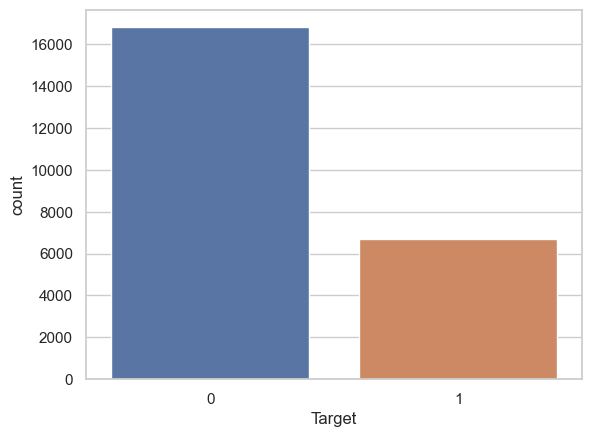

In [19]:
#Distribución de la variable Target
print( train_dataset['Target'].value_counts())
percentage_values = train_dataset['Target'].value_counts(True) * 100 # BEGIN: Calculate percentage values
print(percentage_values)
sns.countplot(x='Target', data=train_dataset)

Encontramos que la distribución de la variable objetivo es aproximadamente 70% 0 y 30% 1

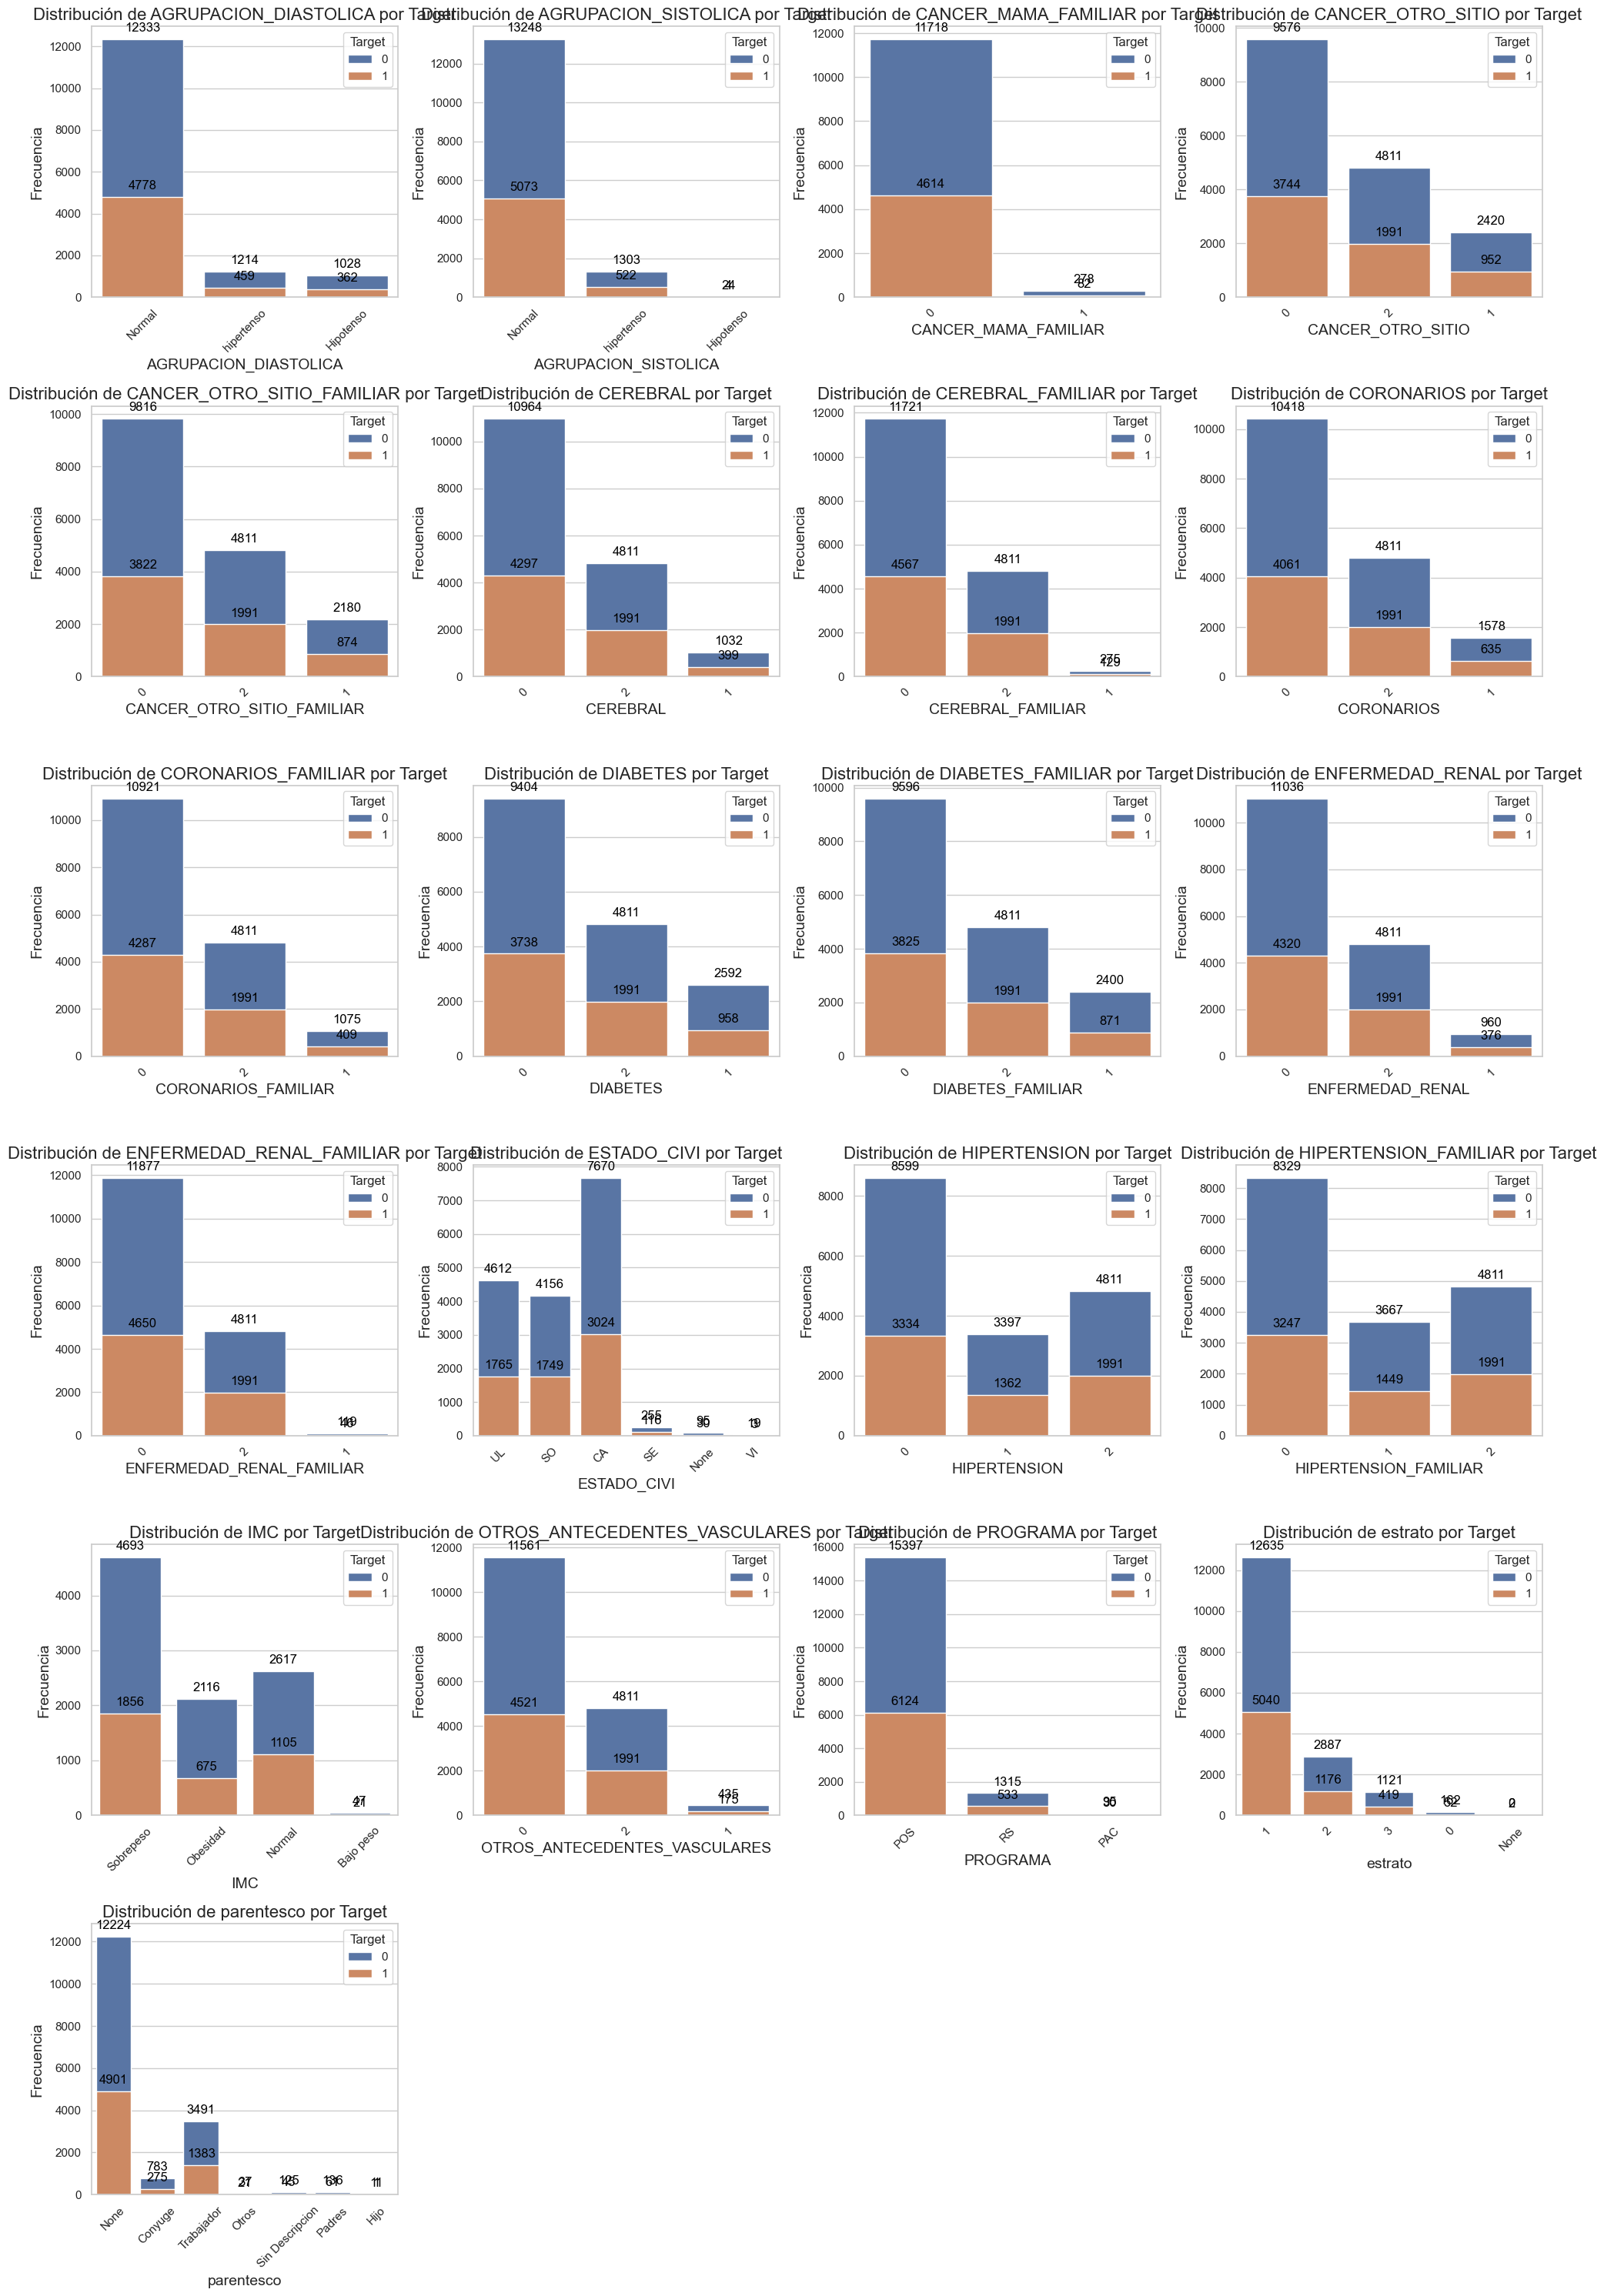

In [20]:
#Distribución de las variables categóricas


# Configurar el estilo de seaborn
sns.set(style="whitegrid")

# Determinar las columnas de tipo objeto y ordenarlas alfabéticamente
categorical_columns = sorted(train_dataset.select_dtypes(include=['object']).columns)

# Establecer el número de gráficos por fila
n_cols = 4
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Calcular el número de filas necesarias

# Crear la figura y los ejes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

# Iterar sobre las columnas categóricas y crear los gráficos
for i, column in enumerate(categorical_columns):
    ax = sns.countplot(data=train_dataset, x=column, hue='Target', ax=axes[i], dodge=False)  # Apilar barras
    axes[i].set_title(f'Distribución de {column} por Target', fontsize=16)  # Títulos de los gráficos
    axes[i].set_xlabel(column, fontsize=14)  # Etiquetas de los ejes
    axes[i].set_ylabel('Frecuencia', fontsize=14)  # Etiqueta del eje y
    axes[i].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad

    # Agregar el valor en la parte superior de cada barra con tamaño de etiqueta aumentado
    for p in ax.patches:
        axes[i].annotate(f'{int(p.get_height())}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='bottom', fontsize=12, color='black',  # Aumentar el tamaño aquí
                         xytext=(0, 5),  # Desplazamiento del texto
                         textcoords='offset points')

# Eliminar los ejes no utilizados
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()  # Mostrar los gráficos

Si anlizamos el gráfico anterior, podemos observar que existen variables con categorías de riesgo (1), con mayor cantidad de personas clasificados como target "1".  Esas variables son: AGRUPACION_DIASTOLICA, CANCER_OTRO_SITIO, CANCER_OTRO_SITIO_FAMILIAR, DIABETES, DIABETES_FAMILIAR, HIPERTENSION e HIPERTENSION_FAMILIAR.

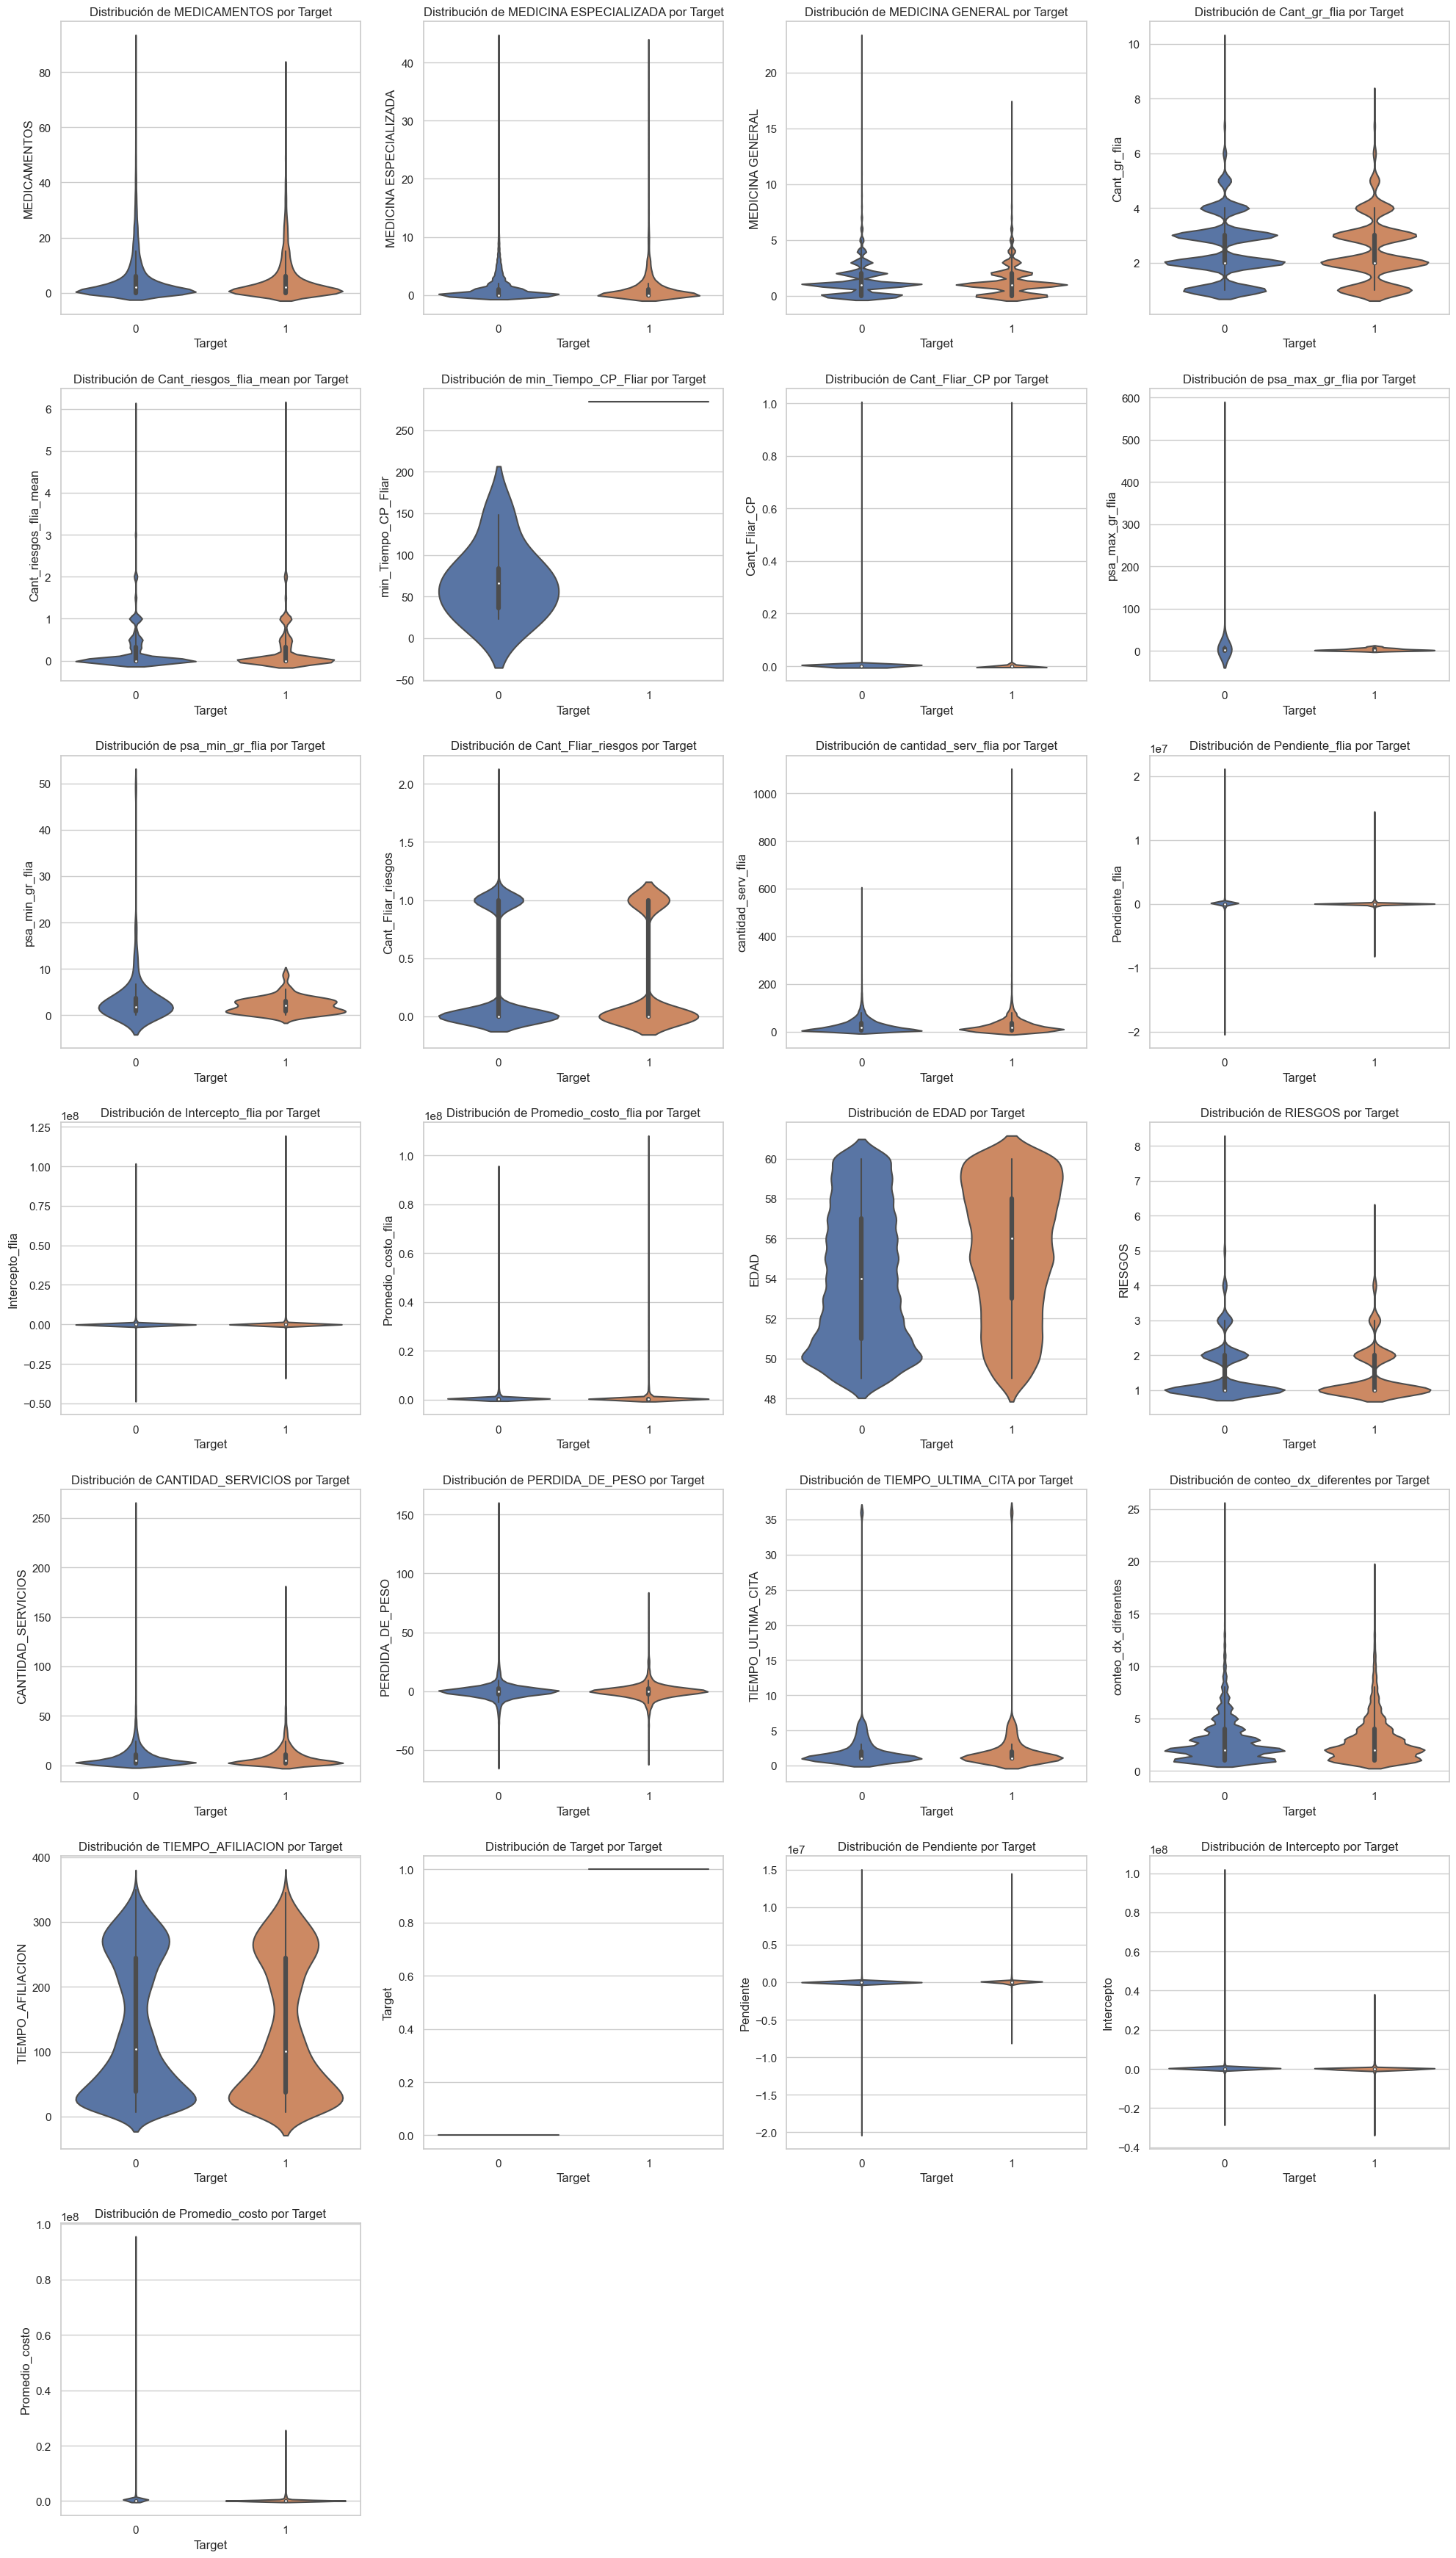

In [21]:
# Seleccionar las columnas continuas (numéricas) excluyendo 'Target'
continuous_columns = train_dataset.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# Determinar el número de filas y columnas del grid
n_cols = 4  # Número de gráficos por fila
n_rows = (len(continuous_columns) + n_cols - 1) // n_cols  # Calcular el número de filas necesario

# Crear la figura para los subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))  # Ajustar el tamaño del gráfico

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Crear un subplot para cada variable continua
for i, column in enumerate(continuous_columns):
    sns.violinplot(x='Target', y=train_dataset[column], data=train_dataset, ax=axes[i])  # Usar el axis específico para cada gráfico
    axes[i].set_title(f'Distribución de {column} por Target')

# Si hay subplots vacíos, esconderlos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()

En el gráfico anterior parece que la edad de las personas con Target = 1 se agrupa en un rango específico (alrededor de los 50-60 años), mientras que para Target = 0 la distribución es más dispersa.

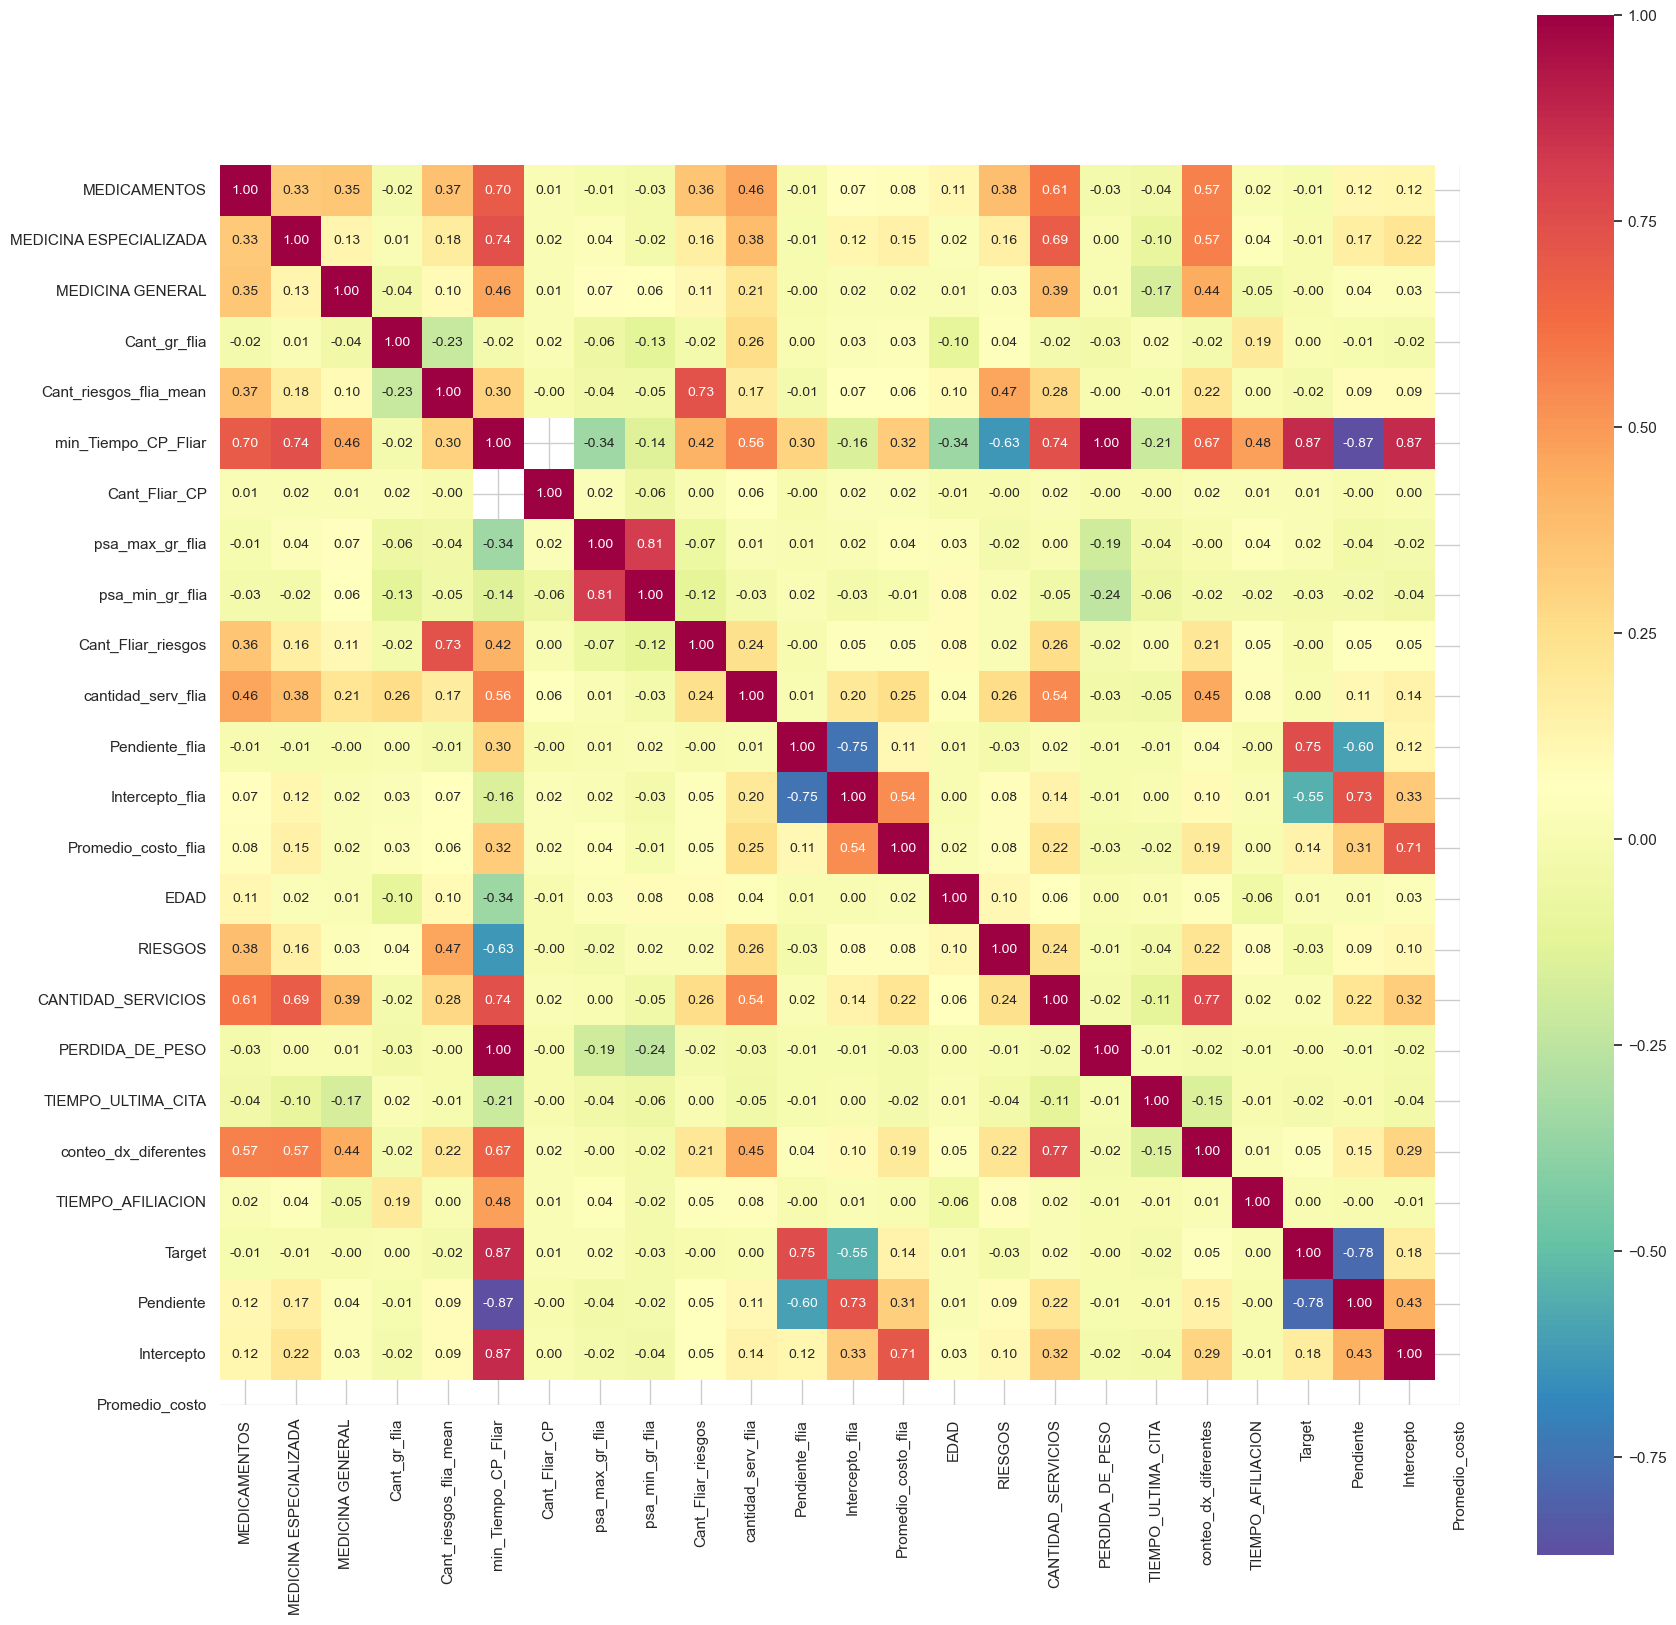

In [22]:
corrmat = train_dataset.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(20, 20))
hm = sns.heatmap(corrmat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10}, #tamaño de la fuente del cuadro
                 yticklabels=train_dataset.select_dtypes(include=['float64', 'int64', 'int32']).columns,
                 xticklabels=train_dataset.select_dtypes(include=['float64', 'int64' ,'int32']).columns,
                 cmap="Spectral_r")
plt.show()

Existen variables que podrían tener multicolinealidad


### 1.1.2. Análisis del baseline

In [23]:
#Split X, y de los datos
X, y = train_dataset.drop(columns="Target"), train_dataset["Target"] #Partimos el dataset de entrenamiento en X y y

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

ROC AUC (Baseline): 0.50


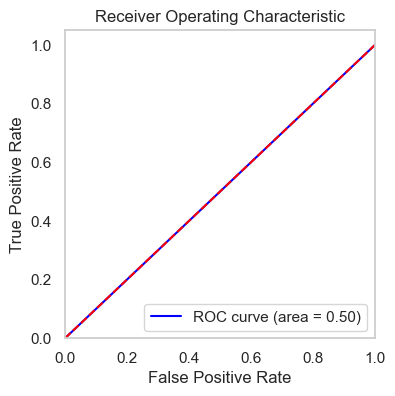

In [25]:
#Crear el clasificaro para baseline (moda)
baseline_classifier = DummyClassifier(strategy='most_frequent')
baseline_classifier.fit(X_train, y_train)
y_pred_prob = baseline_classifier.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva, por eso se coloca 1 o 2da.columna
roc_auc = roc_auc_score(y_test, y_pred_prob) # Calcular el ROC AUC
print(f'ROC AUC (Baseline): {roc_auc:.2f}') # Imprimir el ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # Calcular los valores de la curva ROC
# Graficar la curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 1.2. Identificación de Problemas en los Datos

### 1.2.1: Análisis de Valores Faltantes

Número de valores faltantes por columna:
min_Tiempo_CP_Fliar      23486
psa_max_gr_flia          23330
psa_min_gr_flia          23330
IMC                      10364
AGRUPACION_SISTOLICA      3320
AGRUPACION_DIASTOLICA     3320
RIESGOS                  16283
PERDIDA_DE_PESO          17723
CANCER_MAMA_FAMILIAR      6802
dtype: int64

Porcentaje de valores faltantes por columna:
min_Tiempo_CP_Fliar     99.97
psa_max_gr_flia         99.30
psa_min_gr_flia         99.30
IMC                     44.11
AGRUPACION_SISTOLICA    14.13
AGRUPACION_DIASTOLICA   14.13
RIESGOS                 69.31
PERDIDA_DE_PESO         75.44
CANCER_MAMA_FAMILIAR    28.95
dtype: float64


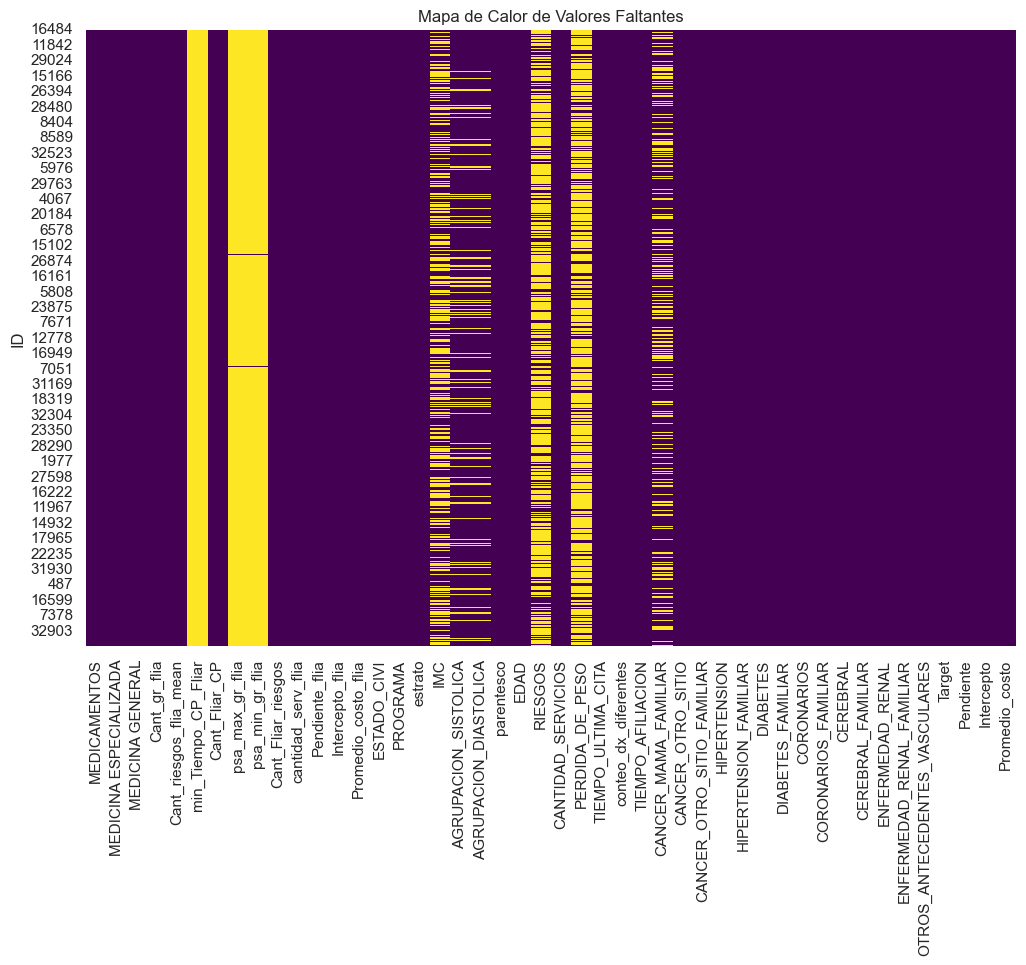

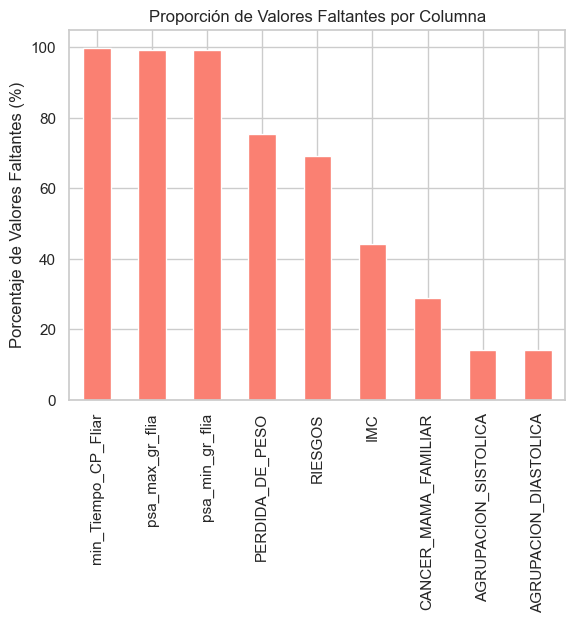

In [26]:
# Ver el número total de valores faltantes en cada columna
missing_values = data_df.isnull().sum()
print("Número de valores faltantes por columna:")
print(missing_values[missing_values > 0])  # Mostrar solo columnas con valores faltantes

# Mostrar la proporción de valores faltantes en porcentaje
missing_percentage = data_df.isnull().mean() * 100
print("\nPorcentaje de valores faltantes por columna:")
print(missing_percentage[missing_percentage > 0])  # Mostrar solo columnas con valores faltantes

# Visualización de valores faltantes con un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

# Visualización de la proporción de valores faltantes con un gráfico de barras
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind='bar', color='salmon')
plt.title('Proporción de Valores Faltantes por Columna')
plt.ylabel('Porcentaje de Valores Faltantes (%)')
plt.show()

1. Variables con una Alta Proporción de Valores Faltantes
- Las variables min_Tiempo_CP_Fliar, psa_max_gr_flia, psa_min_gr_flia y psa_gr_flia tienen un porcentaje de valores faltantes que se acerca o alcanza el 100%. Esto indica que prácticamente toda la información en estas columnas está ausente.
- Conclusión: Es probable que estas columnas no proporcionen suficiente información útil debido al alto porcentaje de valores faltantes. Estas se pueden considerar para eliminar del análisis, ya que imputar un porcentaje tan alto de valores faltantes podría introducir sesgos o no ser útil.

2. Variables con Valores Faltantes Moderados
- Variables como PERDIDA_DE_PESO, RIESGOS y IMC tienen entre un 40% y 60% de valores faltantes.
- Conclusión: Estas variables tienen una cantidad significativa de datos faltantes, pero aún pueden contener información valiosa. En este caso, podría ser viable aplicar técnicas de imputación para completar estos valores y mantener la información.

3. Variables con Bajos Valores Faltantes
- AGRUPACION_SISTOLICA, AGRUPACION_DIASTOLICA, y CANCER_MAMA_FAMILIAR tienen menos del 20% de valores faltantes.
- Conclusión: Para estas columnas, la imputación sería una buena solución, ya que tienen una cantidad manejable de datos faltantes y se puede completar sin distorsionar demasiado la distribución.

### 1.2.2: Análisis de Outliers

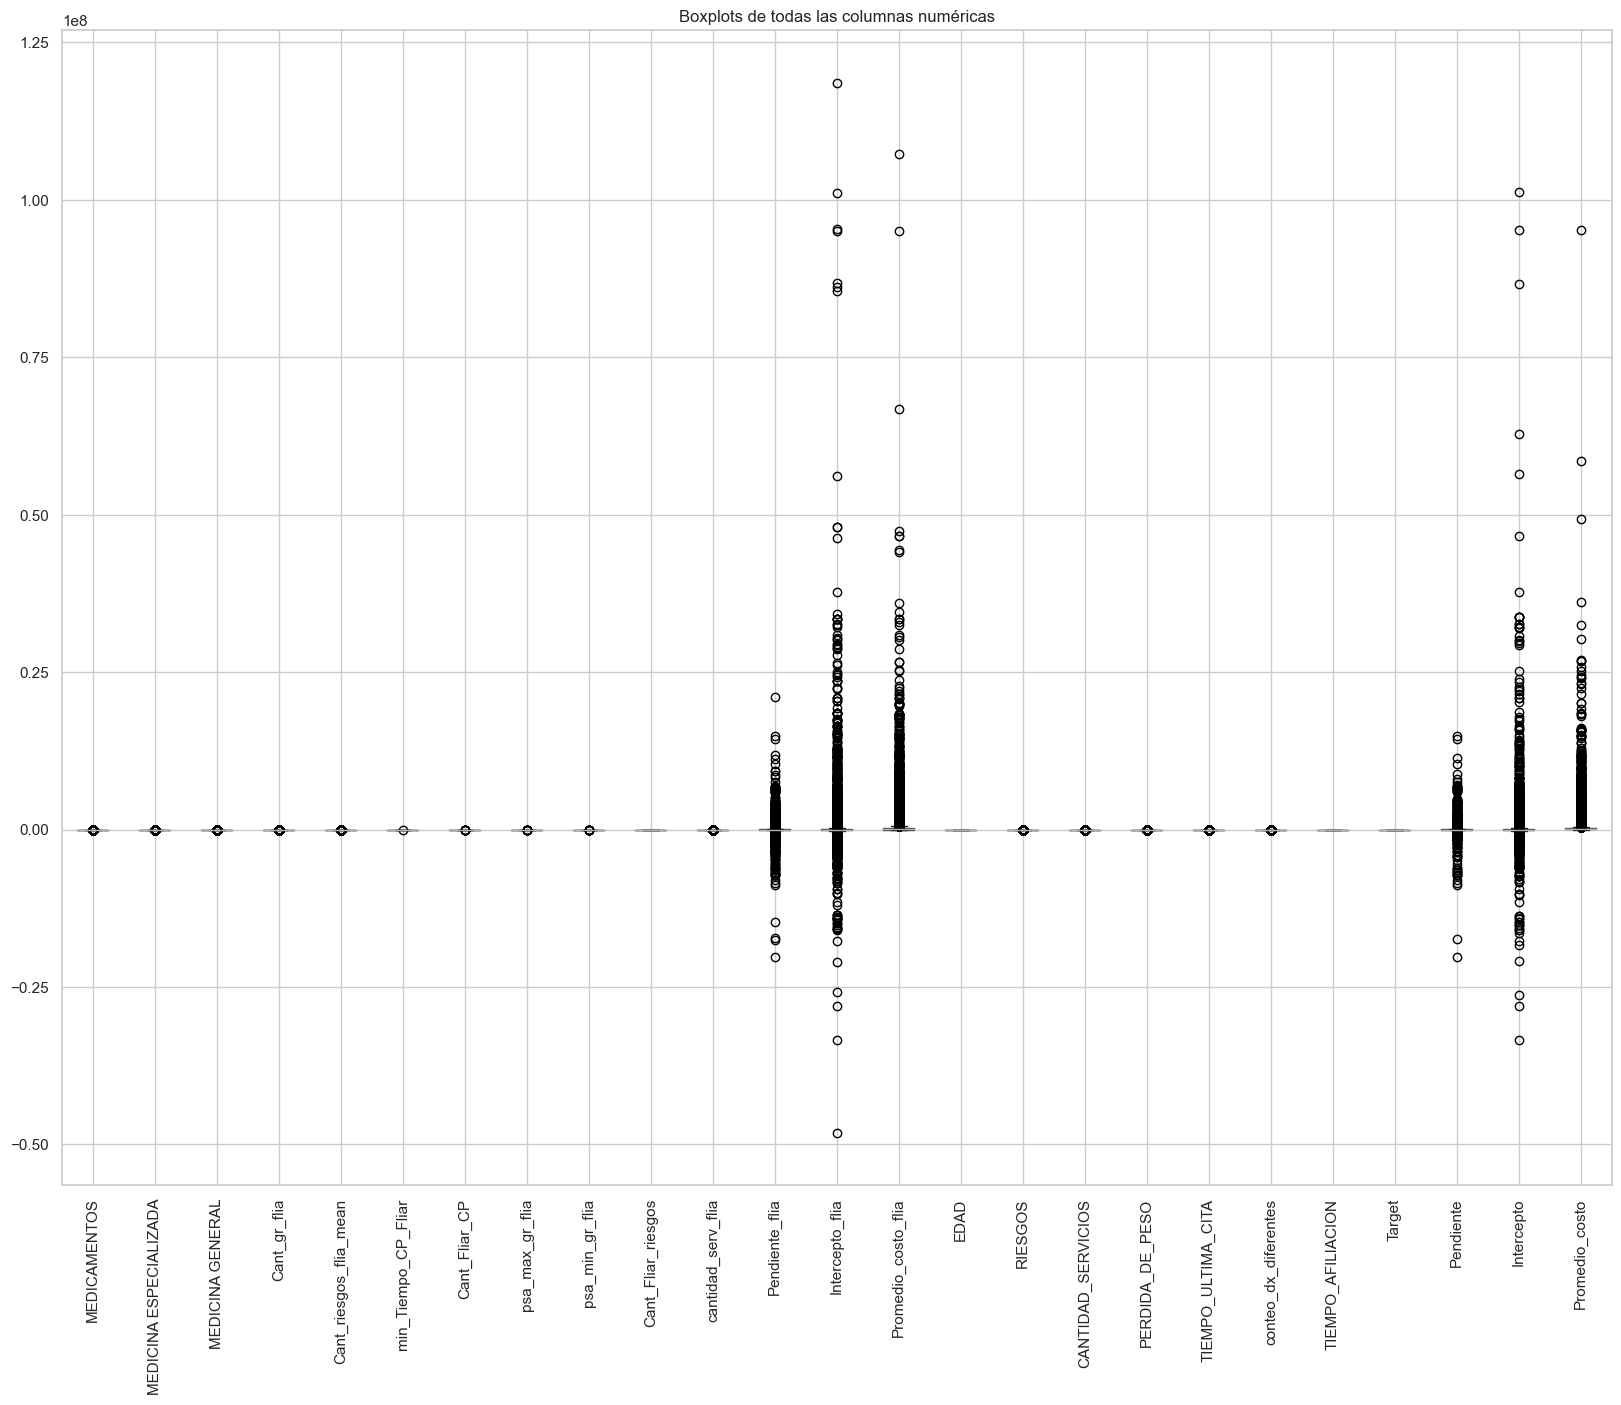

In [27]:
# Visualización de outliers usando boxplots para todas las columnas numéricas
plt.figure(figsize=(20, 15))
data_df.boxplot(rot=90)
plt.title('Boxplots de todas las columnas numéricas')
plt.show()

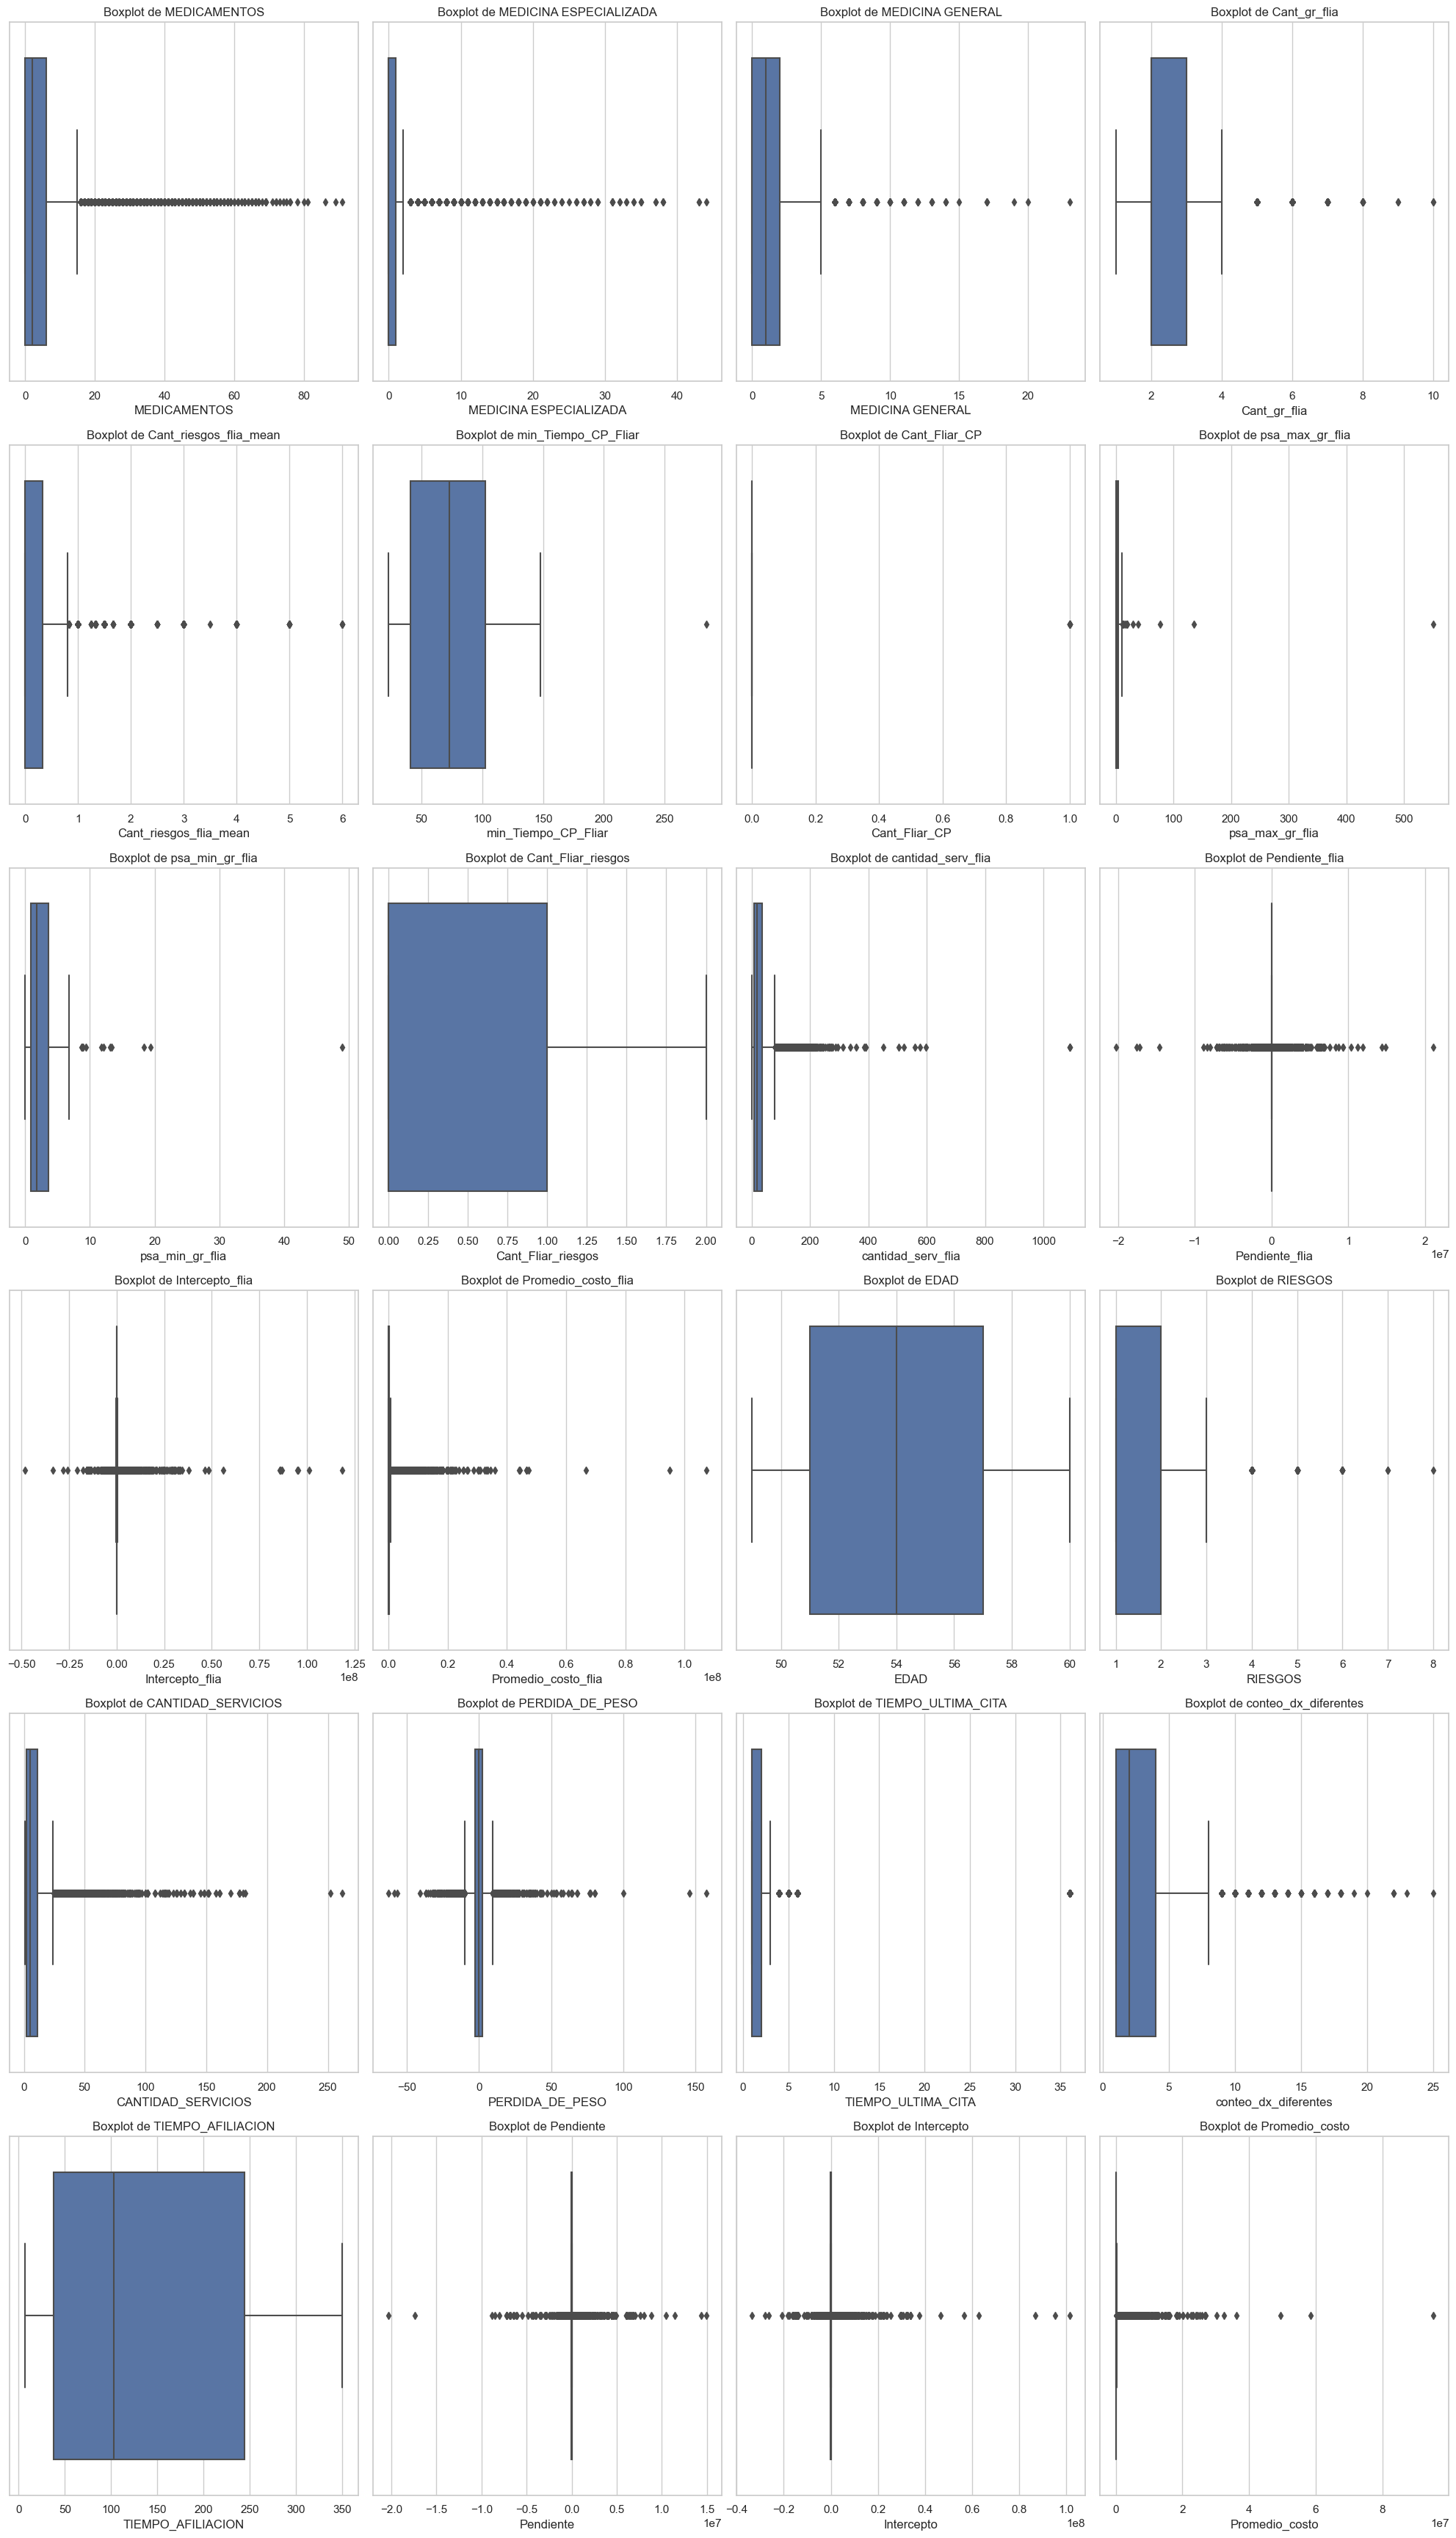

In [28]:
# Visualización de outliers usando boxplots por separado, para todas las columnas numéricas, dibujando 4 graficas por linea
num_columns = X.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(20, 40))
for i, col in enumerate(num_columns):
    plt.subplot(len(num_columns) // 4 + 1, 4, i + 1)
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

Algunas variables muestran una gran cantidad de outliers, lo que podría indicar:

- 1.AGRUPACION_DIASTOLICA y AGRUPACION_SISTOLICA (Tensión Arterial):
Los valores atípicos en estas variables pueden representar mediciones de presión arterial anormalmente altas o bajas. Es probable que estos datos correspondan a pacientes con hipertensión o hipotensión no controlada.

- 2.Cant_Fliar_CP (Familiar con cáncer de próstata):
Dado que esta es una variable binaria o categórica (Sí/No), no debería presentar outliers, pero si el boxplot muestra valores extremos, podría ser por codificación incorrecta o errores en los datos.

- 3.Cant_gr_flia (Cantidad de personas en el grupo familiar):
Aquí los outliers pueden representar familias excepcionalmente grandes. Dependiendo del contexto del análisis, estos valores pueden ser importantes para identificar patrones relacionados con familias numerosas.

- 4.cantidad_serv_flia y CANTIDAD_SERVICIOS (Cantidad de servicios prestados):
Las observaciones atípicas en estas variables podrían reflejar familias o individuos que han utilizado un número significativamente mayor de servicios médicos en el último semestre.

- 5.conteo_dx_diferentes (Número de diagnósticos en el último semestre):
Los valores extremos aquí podrían estar asociados a pacientes con múltiples enfermedades crónicas o comorbilidades.

- 6.EDAD:
En esta variable, los valores atípicos probablemente se encuentren en los extremos del espectro, es decir, individuos muy jóvenes o muy mayores. Estos grupos podrían requerir un enfoque diferente en cuanto a tratamientos y prevención de enfermedades.

- 7.IMC (Índice de Masa Corporal):
Los valores extremadamente altos o bajos de IMC pueden indicar obesidad severa o desnutrición. Estos casos son críticos en el análisis de salud, ya que pueden estar asociados a otras condiciones como diabetes o enfermedades cardiovasculares.

- 8.Pendiente, Pendiente_flia, Intercepto, Intercepto_flia (Costos familiares y personales):
Estas variables muestran outliers que probablemente representan individuos o familias con costos de salud extremadamente altos. Estos podrían estar relacionados con enfermedades crónicas, tratamientos costosos o hospitalizaciones prolongadas.

- 9.Promedio_costo, Promedio_costo_flia:
Al igual que las variables anteriores de costos, los outliers en estas variables probablemente representan promedios excepcionalmente altos en los costos de atención médica de individuos o familias.

- 10.psa_max_gr_flia, psa_min_gr_flia (Resultados de PSA - Cáncer de Próstata):
Los outliers en estos datos pueden corresponder a resultados de PSA anormalmente altos o bajos en familiares de los usuarios, lo que podría indicar un riesgo elevado de cáncer de próstata.

- 11.PERDIDA_DE_PESO (Variación de peso en el último año):
Outliers: Valores atípicos en esta variable pueden reflejar cambios de peso significativos, lo que podría estar asociado a problemas de salud como desnutrición, caquexia (pérdida extrema de peso por enfermedades crónicas) o recuperación postoperatoria.

- 12.TIEMPO_AFILIACION y TIEMPO_ULTIMA_CITA:
Los valores extremos en estas variables pueden representar usuarios que han estado afiliados por mucho tiempo o que no han tenido una cita en mucho tiempo. Podrían ser indicadores de poca adherencia a los servicios de salud o de usuarios fieles al sistema.